In [95]:
# Initialize Otter
import otter
grader = otter.Notebook("hw2.ipynb")

## Homework #2

*Please edit the cell below to add your full name (first and last) and the full names of any group members that you collaborated with on this assignment.* 

Name:   Kaitlyn Huynh
Group Members:   
***

In [96]:
# Set random seed and ensure plots are displayed in the notebook
import numpy as np
rnd_seed = 42
np.random.seed(rnd_seed)
%matplotlib inline
# Additional imports added by me
import pandas as pd
import pymc as pm
from quap import quap
import arviz as az
import seaborn as sns
from scipy import stats

<!-- BEGIN QUESTION -->

**Important Note**: *All solutions to the problems below must use the approaches taught so far in the course for answering the questions. There are other approaches for solving these problems that do not require the use of Bayesian approaches, PyMC, quadratic approximation, etc. However, we will soon encounter problems where those tools lack the functionality that is needed to solve the problems. It will be to your benefit to practice using the approach shown in lecture and found in the textbook to begin practicing for what is to come later. In addition, you will not receive full credit on your answers if you do not use the techniques being taught in the course.*

**Question 1 (20 points)**. Construct a linear regression of weight as predicted by height, using the adults (age 18 or greater) from the Howell1 (`Data/Howell1.csv`) dataset. **Be sure to use a quadratic approximation of the posterior distribution as demonstrated in lecture.**

**Note** : _Complete this exercise without using the `pymc.sample_posterior_predictive` function._

In [97]:
df = pd.read_csv(
    "Data/Howell1.csv", 
    sep=';',  
    header=0
)
df2 = df[df.age >= 18]
H = df2.height
W = df2.weight
with pm.Model() as m_real:
    a = pm.Normal("a", mu=60, sigma=10)
    b = pm.Lognormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    mu = pm.Deterministic(
        "mu", 
        a + b * (H - H.mean())
    )
    
    weight = pm.Normal(
        "weight", 
        mu=mu, 
        sigma=sigma, 
        observed=W
    )
    
    idata, posterior = quap([a, b, sigma], n_samples = 100) # Change number of samples to (?)

Consider the heights listed below which were recorded in the community census, but weights were not recorded for these individuals. Provide predicted weights and 89% HPD intervals for each of these individuals. That is, fill in the table below, using model-based predictions **of outcome weights. This requires simulating weights from the model's data distribution/likelihood using samples from the posterior distribution. Report the average weight prediction for each height in the table.** 

The table can be edited by double-clicking in the cell containing the table, copying the Markdown within the cell, and pasting the contents to another **Markdown cell** which can then be edited.

In [98]:
# Write code here
heights = [140, 160, 175]
idata_thinned = az.extract(idata, num_samples = 100)

a_values = idata_thinned.a.values
b_values = idata_thinned.b.values
H_bar = H.mean()

predicted_weights = []
hpdi_values = []
for height in heights:
    predicted_weight = a_values + b_values * (height - H_bar)
    
    predicted_weights.append(predicted_weight.mean())
    hpdi_value = az.hdi(predicted_weight, hdi_prob=0.89)
    hpdi_values.append(hpdi_value)
    

print("Predicted weights:", predicted_weights)
print("89% HPDI:", hpdi_values)

Predicted weights: [35.74920145718385, 48.393134139293736, 57.876083650876126]
89% HPDI: [array([34.69114944, 36.88756498]), array([47.90643927, 48.9823706 ]), array([56.27632707, 59.60457362])]


|Individual|height|predicted weight|89% interval|
|:---|:---|:---|:---|
| 1 | 140 |  | ( , ) |
| 2 | 160 |  | ( , )|
| 3 | 175 |  | ( , )| 

|Individual|height|predicted weight|89% interval|
|:---|:---|:---|:---|
| 1 | 140 | 35.75 | ( 34.69, 36.89 ) |
| 2 | 160 | 48.39 | ( 47.91, 48.98 )|
| 3 | 175 | 57.88 | ( 56.28, 59.60 )| 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 2 (20 points)**. From the Howell1 dataset, consider only the **people younger than 13 years old**.

In this problem, you will estimate the causal association between age and weight using linear regression. Assume that age influences weight through two paths.
- First, age influences height, and height influences weight.
- Second, age directly influences weight through age-related changes in muscle growth and body proportions.

[*__Run the code cell below__*]

All of this implies the following causal model (represented as a DAG):

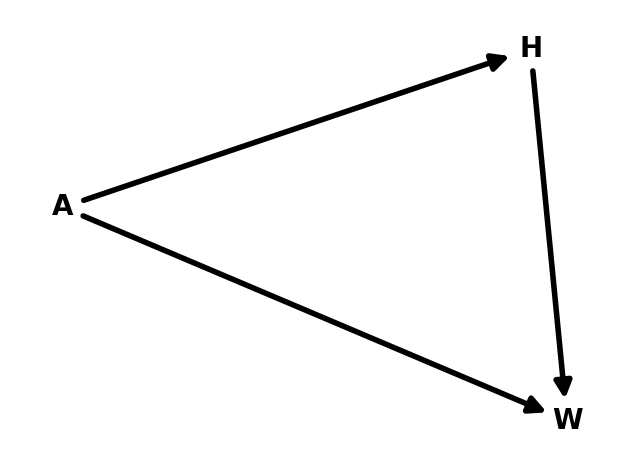

In [99]:
import networkx as nx
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
graph = nx.DiGraph()
graph.add_edges_from([("A", "H"), ("A","W"), ("H","W")])
ax.axis('off')

nx.draw_networkx(
    graph, 
    arrows=True, 
    ax=ax, 
    node_color='none', 
    node_size=1000, 
    font_weight ="bold", 
    font_size=20, 
    width=4, 
    arrowsize=25
)
plt.tight_layout()

Your model intercept will be interpreted as the **expected weight at birth** and the causal effect will estimate how **each year of growth** influences weight.

**Be sure to carefully consider** and **justify the priors** used. *Hint: remember that the intercept represents the expected weight at birth*. Justification for the prior distributions used **must include a prior predictive simulation** to assess the implications of your prior choice. 

**Note** : _For this excercise, perform the prior predictive simulation manually (i.e. do not use `pymc.sample_prior_predictive`)._

Age: 5.401369863013698 years     Weight: 14.693328068493148 kg


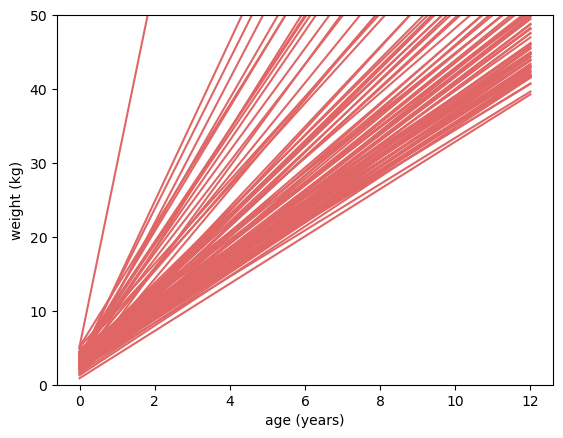

In [100]:

df3 = df[df.age < 13]
# For me to gauge what the sensible weight and height of children < 13 are
# Observed data NOT used in this manual prior predictive simulation
print(f"Age: {df3.age.mean()} years     Weight: {df3.weight.mean()} kg")

manual_sample_size = 100 # Change number of samples 
child_weight = 3 # Typical child weight (kg)
child_weight_deviation = 1 # Typical child standard deviation (kg)
manual_alpha = stats.norm.rvs(child_weight,child_weight_deviation, size=manual_sample_size)
manual_beta = stats.lognorm.rvs(s=1, loc=3, size=manual_sample_size)

Hseq = np.linspace(0, 12, 15) # Child age ranges (years)

for i in range(manual_sample_size):
    plt.plot(
        Hseq, manual_alpha[i] + manual_beta[i] * (Hseq), 
        color="#e06666"
    )

plt.xlabel("age (years)")
plt.ylabel("weight (kg)")
weight_lower_bound, weight_upper_bound = 0, 50 # kg
plt.ylim((weight_lower_bound, weight_upper_bound));

The typical child weight at birth could be around 3 kg with a difference of about +/- 1 kg. This manual prior predictive simulation aligns with biological patterns in reality. As age increases, weight also increases. 

Next, **using a quadratic approximation of the posterior distribution**, estimate the **total (not just direct)** causal effect of **each year of growth** on weight.   
*Be sure to provide your answer in a form that represents the uncertainty of the estimate for this causal effect. A distribution plot is most effective for this purpose.*

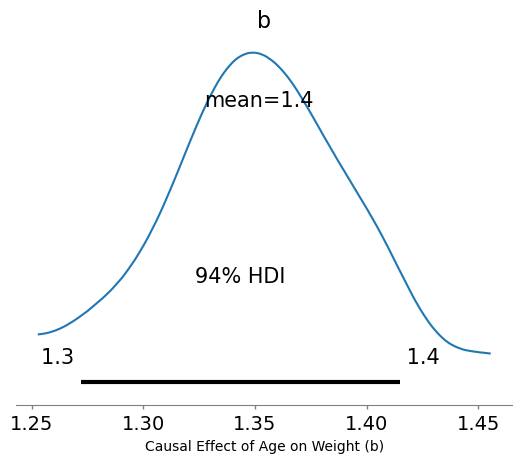

In [101]:
# Data observed from children < 13 years old
df3A = df3.age
df3W = df3.weight
# Create the posterior distribution based on observed data
with pm.Model() as child_model:
    a = pm.Normal("a", mu=15, sigma=10)
    b = pm.Lognormal("b", mu=3, sigma=1) # Rate
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    mu = pm.Deterministic(
        "mu", 
        a + b * (df3A - df3A.mean())
    )
    
    weight = pm.Normal(
        "weight", 
        mu=mu, 
        sigma=sigma, 
        observed=df3W
    )
    
    child_model_idata, child_model_posterior = quap([a, b, sigma], n_samples = 100) # Can change # of samples

az.plot_posterior(child_model_idata, var_names=["b"])
plt.xlabel("Causal Effect of Age on Weight (b)")
plt.show()


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 3 (10 points)**. Now suppose the causal association between age and weight might be different based on reported gender for the same age group as in Question 2. 

Use a single linear regression, with a categorical variable for gender, to **estimate the total causal effect** of age on weight separately for boys and girls.

Be sure to **use index-based encoding of the categories** and **approximate the posterior distribution using a quadratic approximation** as demonstrated in lecture.

In [102]:
gen = df3.male

with pm.Model() as gender_model:
    a = pm.Normal("a", mu=15, sigma=10, shape=2)
    b = pm.Lognormal("b", mu=3, sigma=1, shape=2) # Rate
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    mu = pm.Deterministic(
        "mu", 
        a[gen] + b[gen] * (df3A - df3A.mean())
    )
    
    weight = pm.Normal(
        "weight", 
        mu=mu, 
        sigma=sigma, 
        observed=df3W
    )
    
    gender_model_idata, gender_model_posterior = quap([a, b, sigma], n_samples = 100) # Can change # of samples



How do girls and boys differ according to your model results? **Limit your response to no more than 3 sentences.**
- Provide one or more posterior contrast plots to support your answer.

/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


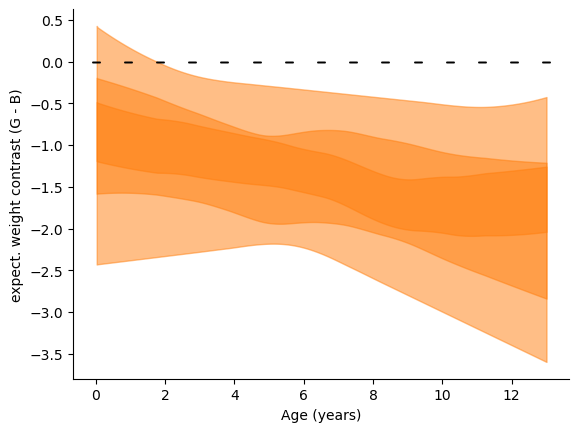

In [103]:
age_seq = np.linspace(0, 13, 15)

data_thin = az.extract(gender_model_idata, num_samples = 100)
mu_pred_G = np.empty((len(age_seq), data_thin.sizes["sample"]))
mu_pred_B = np.empty((len(age_seq), data_thin.sizes["sample"]))

for i, ht in enumerate(age_seq):
    mu_pred_G[i] = data_thin.a.values[0] + data_thin.b.values[0] * (ht - df3.age.mean())
    mu_pred_B[i] = data_thin.a.values[1] + data_thin.b.values[1] * (ht - df3.age.mean())
    
mu_pred_contrast = mu_pred_G - mu_pred_B

for p in [0.5, 0.8, 0.99]:
    _ = az.plot_hdi(age_seq, mu_pred_contrast.T ,hdi_prob=p)
 
    _ = plt.plot(age_seq, [0] * len(age_seq), "_", color='k')
    _ = plt.xlabel("Age (years)")
    _ = plt.ylabel("expect. weight contrast (G - B)")
    _ = sns.despine()

During youth ages 0 through ~8 years old, it seems that boys show a higher rate of weight gain due to the negative results of G - B. Once these differences hit ages 9 - 12 the weight gain is still higher in boys and more rapid as the change appears to be negatively steeper.

In [104]:
grader.check("q3")

q3 results: All test cases passed!

<!-- END QUESTION -->



## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Before attempting to export your work for submission follow this process: First, make sure you have run all cells in your notebook **in order**. Then, **save your notebook**. Finally, run the export cell below. This sequence of actions will ensure that all code/output/plots appear in the generated PDF. **Only the PDF** will be evaluated for grading purposes.  When executed, the cell below will generate a zip file for you to submit. After making your submission on Gradescope, be sure to **review your submitted PDF** to ensure that it contains all of the work that you want evaluated.

In [105]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q3 results: All test cases passed!
